In [1]:
# %load inference_4_beams.py
#!/usr/bin/env python

# In[1]:


import numpy as np;
import torch as T;
import copy ;
import time;
import matplotlib.pyplot as plt;
import scipy.optimize
import os;

import Pyccat;
from Pyccat import field_calculation;
from Pyccat import Make_fitfuc;
from Pyccat import Model;

import Kirchhoffpy;
from Kirchhoffpy.Spheical_field import spheical_grid;
from Kirchhoffpy.coordinate_operations import Coord;
from Kirchhoffpy.inference import correctphase;
from fitting_error_plot import error_plots

DEVICE0=T.device('cpu');

# get the file name of the input parameters;
inputfile='CCAT_model';
# read coordinates of the measured maps;
sourcefile='beam'
# get the measured beam data;
measuredbeams='input_beams/GRASP_296GHz_101_101.txt'
             


# In[2]:


# 1. the first calculation used to perpare the matrixes to speed up the calculations;
defocus0=[400,400,600];
defocus1=[400,-400,600];
defocus2=[-400,400,600];
defocus3=[-400,-400,600];

# initial panel errors;
ad_m2=np.zeros(5*69);
ad_m1=np.zeros((5,77));
# first acurrate forward calculations;
forward_func,ad2_x,ad2_y,ad1_x,ad1_y=Make_fitfuc(inputfile,sourcefile,defocus0,defocus1,defocus2,defocus3,ad_m2,ad_m1)


0
time used: 39.584871199999725
1
time used: 38.24320700000044
2
time used: 38.67988199999945
3
time used: 39.03895369999918


In [4]:
S0=np.genfromtxt('input_beams/input_error_panel.txt')
#S0=np.zeros(5*146)
paraA=T.tensor([1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0],dtype=T.float64).to(DEVICE0)
paraP=T.tensor(np.zeros(5*4),dtype=T.float64).to(DEVICE0)
start=time.time()
x=forward_func(T.tensor(S0,dtype=T.float64).to(DEVICE0),paraA,paraP)
print(time.time()-start)

1.0970005989074707


In [5]:
x

tensor([[ 4.0292e-06,  2.3496e-06, -6.0288e-08,  ..., -1.2815e-06,
         -1.0171e-05, -1.1836e-05],
        [-1.1747e-06, -8.3829e-06, -1.0769e-05,  ..., -9.8754e-06,
         -1.2954e-05, -4.3767e-06],
        [-8.7423e-07,  1.4577e-07,  4.3628e-06,  ..., -1.5507e-06,
          1.2547e-06,  1.7498e-06],
        ...,
        [ 2.3420e-06, -3.1872e-06, -4.8173e-06,  ..., -1.1965e-07,
         -5.9092e-06, -2.8741e-06],
        [ 4.6637e-07,  1.1931e-06,  2.9358e-06,  ...,  1.6388e-06,
         -2.6163e-06, -1.0622e-06],
        [-3.0640e-06,  5.8529e-06,  9.4533e-07,  ...,  1.1630e-05,
          1.1384e-05,  1.1704e-05]], dtype=torch.float64)

In [3]:
S0=np.genfromtxt('input_beams/input_error_panel.txt')
paraA=T.tensor([1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0],dtype=T.float64)
paraP=T.tensor(np.zeros(6*4),dtype=T.float64)
start=time.time()
x=forward_func(T.tensor(S0,dtype=T.float64),paraA,paraP)
print(time.time()-start)
test=T.tensor(np.genfromtxt(measuredbeams,delimiter=','))
Test=correctphase(test)
X=correctphase(x)

1.2104532718658447


In [19]:
# 2.define the function used in least-square fitting loops;

'''
includes the large-scale parameters
'''
def inference(Lambda_00,Lambda_10,Lambda_01,Lambda_20,Lambda_02,measuredbeams,SNR=70):
    '''
    1. Lambda_00,Lambda_01,Lambda_10,Lambda_20,Lambda_02, parameters used to compress the degeneracy
    in large scale, which is the intrinsic degeneracy of the two-mirror system;
    2. measuredbeam, the input measured data;
    3. noise added to the 
    '''
    ''' get the locations of the adjusters'''
    x2=T.tensor(ad2_x).to(DEVICE0);
    y2=T.tensor(ad2_y).to(DEVICE0);
    x1=T.tensor(ad1_x).to(DEVICE0);
    y1=T.tensor(ad1_y).to(DEVICE0);
    '''read the measured beams'''
    test=np.genfromtxt(measuredbeams,delimiter=',');
    test=T.tensor(test).to(DEVICE0);
    test=correctphase(test)

    def fitfuc(parameters):
        '''input parameters put to tensor type'''
        Params=T.tensor(parameters,requires_grad=True);
        '''CPU OR GPU'''
        parameters=Params.to(DEVICE0)
        
        '''adjusters'''
        adjusters=parameters[0:5*(69+77)];
        '''large scale error in amplitude'''
        paraA=parameters[5*(69+77):5*(69+77)+6*4];
        '''large scale error in phase term (pointing error, curvature erorr)'''
        paraP=parameters[5*(69+77)+6*4:];
        '''forward calculation'''
        
        Data=forward_func(adjusters,paraA,paraP);
        Data=correctphase(Data)
        '''residual between simulation and measurement'''
        r0=((Data-test)**2).sum();
        
        # consider the lagrange factors
        S2=adjusters[0:5*69];
        S1=adjusters[5*69:];        
        Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        Z_10=T.abs((x2*S2).sum())+T.abs((x1*S1).sum()) # compress slope error in x
        Z_01=T.abs((y2*S2).sum())+T.abs((y1*S1).sum());# slope error in y
        Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        Z=(S2**2).mean()+(S1**2).mean()
        r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_01*Z_01+Lambda_20*Z_20+Lambda_02*Z_02+Lambda0*Z
        
        #Z_00=T.abs((S1).sum())+T.abs((S2).sum()); # compress piston error in large scale;
        #Z_10=(S1**2).mean()+(S2**2).mean();
        #Z_20=T.abs((S2*x2**2).sum())+T.abs((S1*(x1**2)).sum()); #  curvature error;
        #Z_02=T.abs((S2*y2**2).sum())+T.abs((S1*(y1**2)).sum());
        #r=r0+Lambda_00*Z_00+Lambda_10*Z_10+Lambda_20*Z_20+Lambda_02*Z_02;
        print(Z_00.item(),Z_10.item(),Z_01.item(),Z_20.item(),Z_02.item());
        
        r=r.sum();
        r.backward()
        print(r.item())
    
        return r.data.cpu().numpy(),Params.grad.data.cpu().numpy();
    
    '''initial input parameters'''
    ad=np.zeros(5*146+(6+5)*4); 
    ad[5*146]=1;ad[5*146+6*1]=1;
    ad[5*146+6*2]=1;ad[5*146+6*3]=1;
    
    start=time.perf_counter();
    results=scipy.optimize.minimize(fitfuc,ad,method="BFGS",jac=True,tol=1e-6);
    elapsed =(time.perf_counter()-start);
    print('time used:',elapsed);
    
    return results;

'''
start the fitting process;
'''
measuredbeams='input_beams/GRASP_296GHz_101_101.txt'      
results=inference(1*10**(-1),1*10**(-1),1*10**(-1),1*10**(-1),1*10**(-1),measuredbeams);
'''
save data
'''
filename='output/inference/test/'
if not os.path.exists(filename):
    os.makedirs(filename);
file_input='input_beams/input_error_panel.txt'
adjuster0=np.genfromtxt(file_input)
np.savetxt(filename+'results'+'.txt',results.x)
np.savetxt(filename+'fitting_error'+'.txt',-results.x[0:5*146]+adjuster0);

0.0 0.0 0.0 0.0 0.0
0.5263687139405827
0.02307381607207558 0.05824550440098957 0.6231961555431305 0.23421306575975662 0.4927311289577072
6.118789664354324
0.0022315087747927353 0.005633023759790395 0.060270381161380275 0.022651151841611452 0.04765288214346655
0.393520837885702
0.7712946237298061 0.22502861428239718 0.1407380065977083 0.24339029667217718 0.29911667944538556
0.517196543111623
0.1742726901168722 0.04699964878593439 0.01440402582953617 0.05344315017778221 0.06187908702951881
0.39535143434513864
0.06034161492072642 0.013025969908971077 0.04401013838152623 0.017195097280320964 0.026483735480974997
0.38807535061977494
0.06652987115820772 0.013511062314089026 0.02861165930809223 0.013896511658121998 0.01726634906281121
0.3787656391744244
0.06019473123358526 0.011802242758014309 0.005314029562014239 0.010322602116765838 0.014831910183160501
0.3612763353234838
0.053401152470364435 0.008070120064103962 0.03220786889324033 0.007356305744083701 0.011100997601694602
0.33537280243556

In [ ]:
'''
results plots
'''
filename='output/inference/test/'
file_input='input_beams/measured_beam_maps_51/panel_error_296GHz.txt'
name='1'
error_plots(file_input,filename+'results1.txt',name,inputrms=100,outputrms=10,scale=10)

In [ ]:
results.x[0:5*146]-adjuster0

In [ ]:
error_plots('input_beams/input_error_panel.txt',filename+'results'+'.txt','test',inputrms=100,outputrms=15,scale=15)

In [10]:
results.x

array([-5.85055094e-02, -4.50576147e-02, -2.04326456e-02,  6.29834763e-02,
        5.56039353e-02, -5.58460178e-02, -6.36288346e-02, -4.16300116e-02,
        1.30166991e-02,  4.60544920e-02,  1.04789452e-01,  6.94336712e-02,
       -7.94219851e-03, -6.23496849e-02, -5.91731445e-02, -8.11231326e-03,
        9.71576094e-03,  2.94669995e-02,  4.28420260e-02,  9.12199598e-02,
        4.15126305e-02,  2.51568731e-02, -6.17584193e-02, -2.28840625e-02,
       -1.47966662e-02,  2.41260775e-02,  1.30944721e-02,  4.42803371e-02,
       -2.12963716e-02,  2.34435238e-03, -1.61078623e-02, -2.08726298e-02,
       -8.20238031e-03, -1.04607526e-02, -1.23763451e-02, -7.56520506e-03,
        1.45264425e-02,  2.83902971e-02,  9.55078262e-03,  3.37144159e-02,
       -2.05689534e-04,  2.07982654e-04, -3.83644476e-03,  3.72183138e-03,
        7.92026179e-03,  4.36221544e-03, -6.12167612e-02, -7.19119532e-02,
        6.82659082e-02,  4.38209850e-02, -2.20680787e-02,  2.82486832e-02,
        6.46467099e-04,  

In [16]:
dx=(-results.x[0:5*146]+adjuster0)*1000

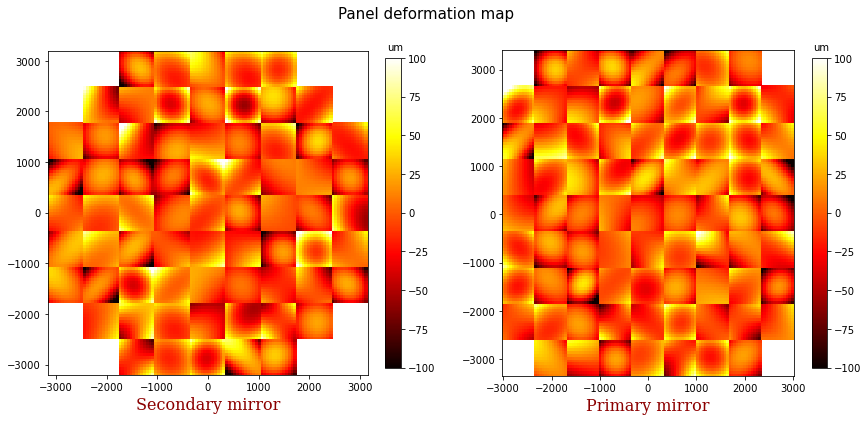

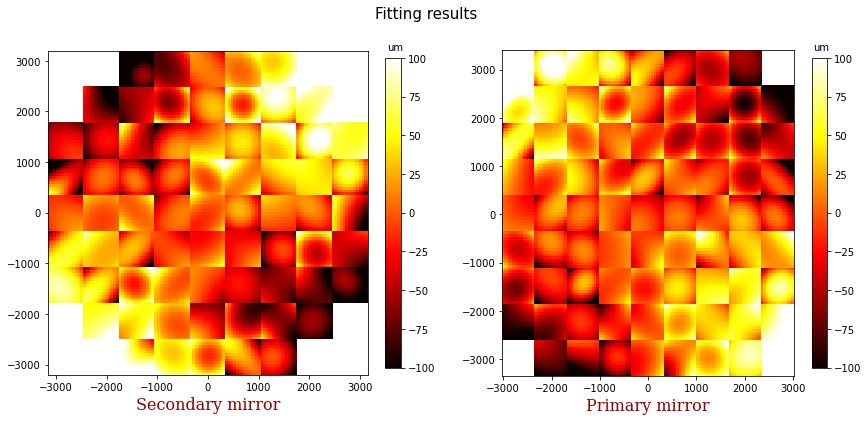

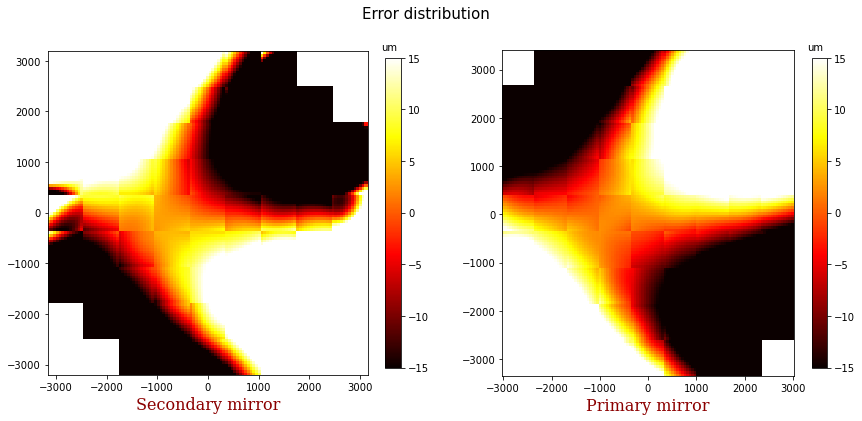

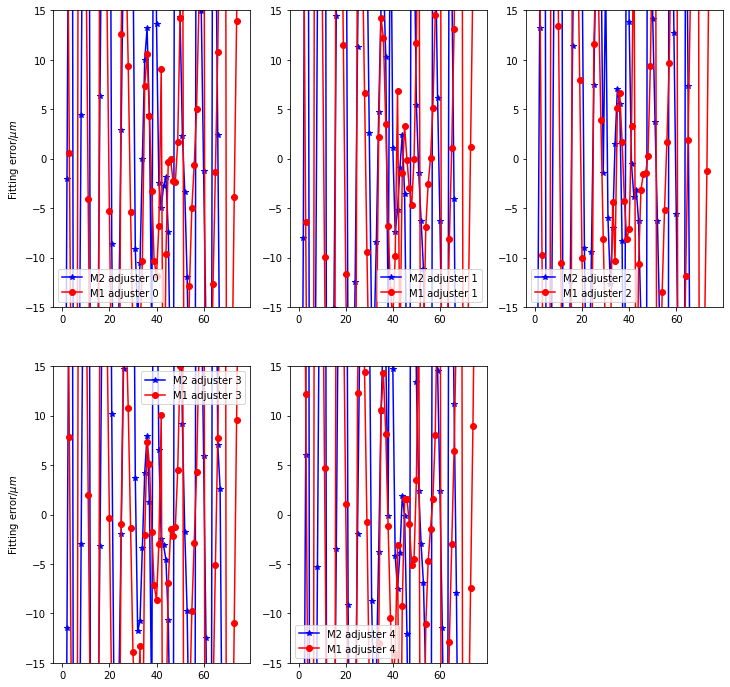

 M2 error: 43.14502159286195 um
 M1 error 38.696750944322034 um


In [33]:
error_plots('input_beams/input_error_panel.txt',filename+'results'+'.txt','test',inputrms=100,outputrms=15,scale=15)

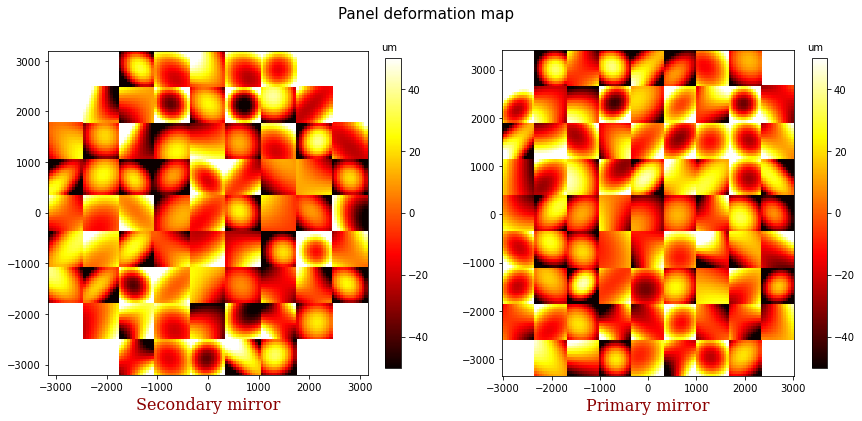

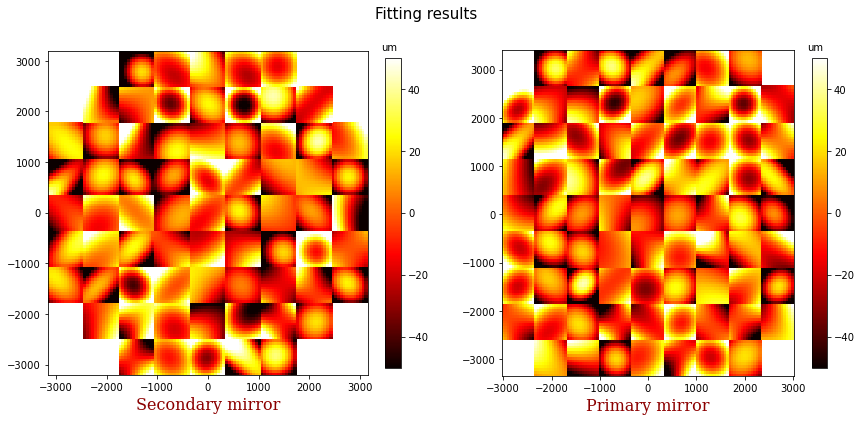

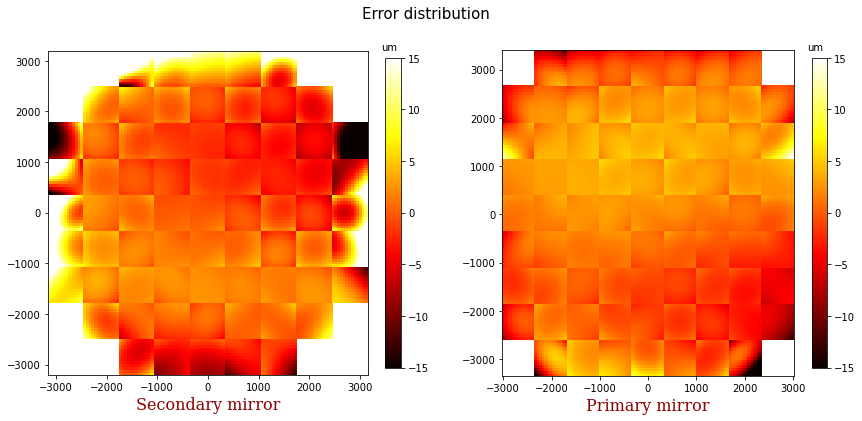

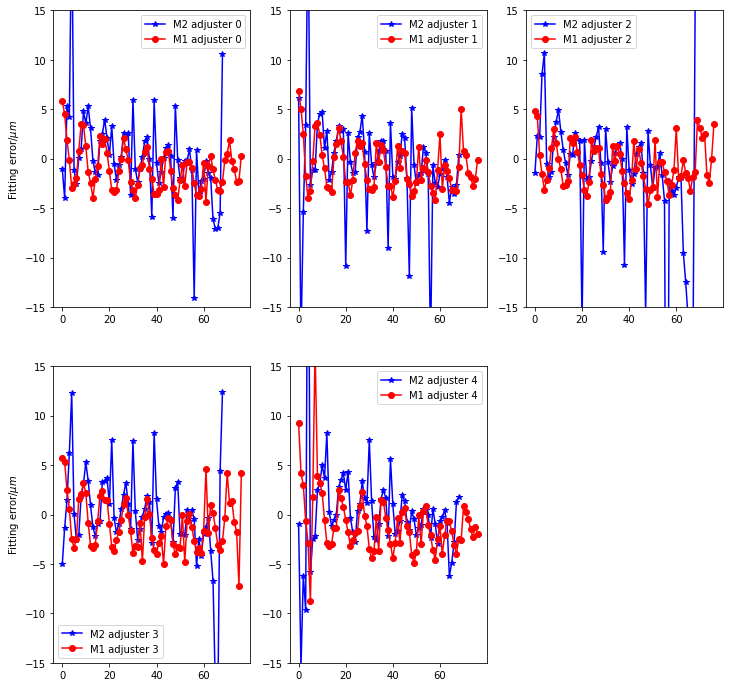

 M2 error: 6.930949476435738 um
 M1 error 2.9155189693231325 um


In [39]:
error_plots('input_beams/input_error_panel.txt',filename+'results_test_LP'+'.txt','test',inputrms=50,outputrms=15,scale=15)

In [32]:
np.sqrt(0.00059 /2)*1000

17.175564037317667

In [37]:
0.0075852768280268885+10*0.0007517907478668205

0.015103184306695093

In [38]:
0.008337178345084217-0.0075852768280268885

0.0007519015170573285